In [53]:
import os
import inspect
import sys
import pandas as pd
import charts
import numpy as np
import pylab as pl
from scipy import spatial
from scipy.spatial import distance
import time
import math

from opengrid.library import houseprint

In [54]:
hp = houseprint.Houseprint()

Opening connection to Houseprint sheet
Opening spreadsheets
Parsing spreadsheets
30 Sites created
30 Devices created
87 sensors created
Houseprint parsing complete


In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 16,8

In [56]:
gas = hp.find_sensor('212ce724e124fbde0fb649396375d099')

In [57]:
head = pd.Timestamp('20151110')
tail = pd.Timestamp('20151118')
originalGraph = gas.get_data(head=head, tail=tail, diff=True, resample='min', unit='kW')
charts.plot(originalGraph, stock=True, show='inline')

Using tmpo database from /data/.tmpo/tmpo.sqlite3


In [58]:
def euclideanDistance(s1,s2):
    #Verwacht een numpy array
    dist = np.linalg.norm(s1-s2)
    return dist

In [59]:
def cosineSimilarity(s1,s2):
    similarity = 1 - spatial.distance.cosine(s1, s2)
    return similarity

In [60]:
def mahalanobisDistance(s1,s2):
    similarity = 1 - distance.mahalanobis(s1,s2)
    return similarity

In [61]:
def manhattanDistance(s1,s2):
    difference=diffArrays(s1,s2)
    absDifference=abs(difference)
    sumOfValues=np.sum(absDifference)
    maxValues=np.maximum(s1,s2)
    maxValues=np.max(maxValues)
    manhattan=sumOfValues/maxValues
    return manhattan

In [62]:
def hammingDistance(s1, s2):
    """Return the Hamming distance between equal-length sequences"""
    if len(s1) != len(s2):
        raise ValueError("Undefined for sequences of unequal length")
    return sum(el1 != el2 for el1, el2 in zip(s1, s2))

In [11]:
def paa_transform(timeSeries, n_pieces):
    splitted = np.array_split(timeSeries, n_pieces) ## along columns as we want
    return np.asarray(map(lambda xs: xs.mean(axis = 0), splitted))

In [12]:
def znormalization(ts):
    #Pakt mean, std van kolom.
    meanCalc = ts.mean(axis = 0)
    stdCalc = ts.std(axis = 0)
    return (ts - meanCalc) / stdCalc

In [13]:
def sax_transform(ts, n_pieces, alphabet):
    """
    ts: columns of which are time serieses represented by np.array
    n_pieces: number of segments in paa transformation
    alphabet: the letters to be translated to, e.g. "abcd", "ab"
    return np.array of ts's sax transformation
    Steps:
    1. znormalize
    2. paa
    3. find norm distribution breakpoints by scipy.stats
    4. convert paa transformation into strings
    """
    from scipy.stats import norm
    alphabet_sz = len(alphabet)
    thrholds = norm.ppf(np.linspace(1./alphabet_sz, 
                                    1-1./alphabet_sz, 
                                    alphabet_sz-1))
    def translate(ts_values):
        return np.asarray([(alphabet[0] if ts_value < thrholds[0]
                else (alphabet[-1] if ts_value > thrholds[-1]
                      else alphabet[np.where(thrholds <= ts_value)[0][-1]+1]))
                           for ts_value in ts_values])
    paa_ts = paa_transform(znormalization(ts), n_pieces)
    return np.apply_along_axis(translate, 0, paa_ts)

In [14]:
def makeArray(array1):
    arrayValues=[]    
    for i in range(0, array1.size-1):
        if(i<array1.size):
             arrayValues.append(ord(array1.iloc[i])-97)
    df=pd.DataFrame(arrayValues)
    return df

In [15]:
def makeDiffArray(array): #Excepts a letter array
    arrayValues=[]    
    for i in range(0, array.size-1):
        if(i<array.size):
             arrayValues.append(ord(array.iloc[i+1])-ord(array.iloc[i]))
    df=pd.DataFrame(arrayValues)
    return df          


In [16]:
def differenceNumbers(array): #Expects array of numbers @
    arrayValues=[]
    for i in range(0, array.index.size):
        arrayValues.append(np.diff(array.iloc[i], axis=-1))
    df=pd.DataFrame(arrayValues)
    return df

In [17]:
def diffArrays(array1,array2):
    array=[]
    if array1.index.size==array2.index.size:
        for i in range(0,array1.index.size):
            array.append(array2.iloc[i]-array1.iloc[i])
    df=pd.DataFrame(array)
    return df

In [18]:
zScores=znormalization(originalGraph)

# Visualisation of the different graphs (PAA, SAX, original graph, zscores)

/usr/lib/pymodules/python2.7/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


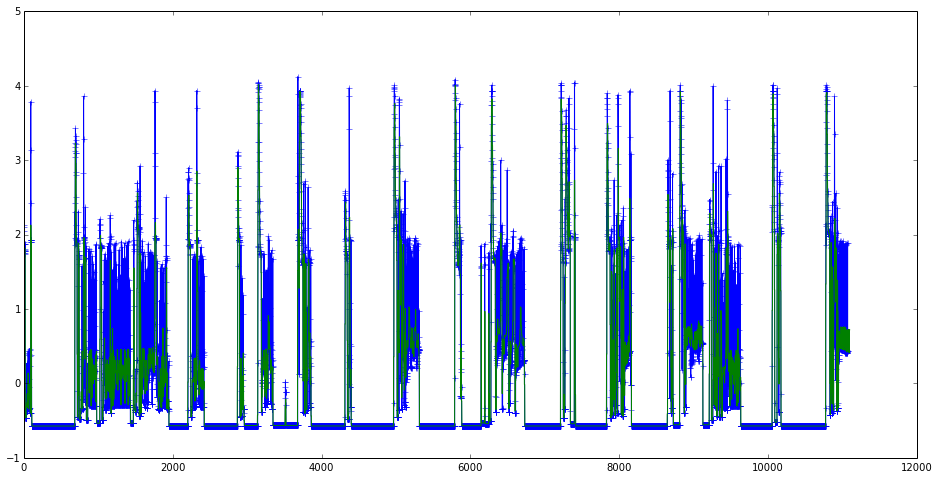

In [19]:
paaTransform = paa_transform(zScores,1850)
paaTransfo = np.repeat(paaTransform,6, axis = 0)
pl.figure()
pl.plot(zScores, '-+')
pl.plot(paaTransfo)
pl.legend(loc = "upper left")

In [20]:
originalGraphDf=pd.DataFrame(originalGraph)
paaTransfoDf=pd.DataFrame(paaTransfo)
paaTransfoDf=paaTransfoDf.iloc[:paaTransfoDf.size-27]
paaTransfoDf.index=originalGraphDf.index
graph = pd.concat([paaTransfoDf,zScores],axis=1).dropna()
charts.plot(graph,stock=True,show='inline')


In [21]:
saxTransformation=sax_transform(originalGraph, 1850, "abcdefghijklmn")

In [22]:
'''
Werkwijze:
Dataframes gebruiken!
-sax transfo
-letters->nummers (makeArray())
-np.repeat (plateau's)
-plot(paa_transform+repeater,^)
'''

letters=pd.DataFrame(saxTransformation)
letters.columns=['col1']
lettersToNumSax=makeArray(letters.col1) #Expects a pandaframe

repeatedValues=np.repeat(lettersToNumSax.as_matrix(),6) #expects an array

dfRepeatedValues=pd.DataFrame(repeatedValues)

dfRepeatedValues=dfRepeatedValues.iloc[:dfRepeatedValues.size-21]
paaTransfoDf.index=dfRepeatedValues.index

concatinatePaaAndSax=pd.concat([znormalization(dfRepeatedValues),paaTransfoDf],axis=1)
concatinatePaaAndSax.columns=['col1','col2']

charts.plot(concatinatePaaAndSax,stock=True,show='inline')


In [23]:
dfRepeatedValues.index=zScores.index
saxVsOriginalGraph=pd.concat([(dfRepeatedValues), znormalization(originalGraph)],axis=1).dropna()
charts.plot(saxVsOriginalGraph, stock=True, show='inline')

In [24]:
saxVsOriginalGraph2=pd.concat([(dfRepeatedValues), (originalGraph)],axis=1).dropna()
charts.plot(saxVsOriginalGraph2, stock=True, show='inline')

In [25]:
originalGraphDf['a']

KeyError: 'a'

# Storing comparing arrays used in the methods below

In [26]:
dfCompare=dfRepeatedValues.ix[pd.Timestamp('2015-11-13 16:25:00+00:00'):pd.Timestamp('2015-11-13 17:16:00+00:00')]
dfCompare2=dfRepeatedValues.ix[pd.Timestamp('2015-11-14 15:25:00+00:00'):pd.Timestamp('2015-11-14 16:45:00+00:00')]

# Old method without timestamp correction

In [38]:
 def calculateWeightsNew(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)

    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        #print "Value now:", arrayWithValues[i]
        i=i+1
        valuesToArray=np.array(valuesList)
        #print "i:",i
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            #print "i:",i, "compare", arrayToCompare.size+j
            if(j==0) or (euclideanDistance(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                resultList.append([euclideanDistance(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
            j=j+1
            i=j
            startingTimeStamp=dfWithValues.index[j]
            stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
            valuesList=[]
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves):
            #print "currentsaves", currentSaves, [value,timeStamp]
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex][0], resultList[loopIndex][1], resultList[loopIndex][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Euclidean','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Euclidean']:
            #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
#             if(resultList[loopIndex-1][2] > resultList[loopIndex-2][2]) and (resultList[loopIndex-1][2] < resultList[loopIndex][2]):
#                 #value is between start and stop time     
#                 dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,timeStamp]
#             else:
#                 dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,timeStamp]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['Euclidean'])
    print(time.time()-start)
    return dfResult
                    

# New method with timestamp correction and automatic graph creation

In [49]:
 def calculateWeightsNew(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
    start=time.time()
    #Create list where values on which the different methods will act will be saved temporarily
    #This list will be cleared every time
    valuesList=[]

    #Create list with results of the methods
    resultList=[]
    dfResult=pd.DataFrame(resultList)

    compareToArray=np.array(arrayToCompare)
    i=0 #Loops through list arrayToCompare.size times
    j=0 #Amount of values considered, and calculated.
    loopIndex=0 #Loops through the resultslist, as long as its size
    currentSaves=0 #Current amount of variables saved
    arrayWithValues=np.array(dfWithValues)
    startingTimeStamp=dfWithValues.index[0]#Todo with speed
    stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
    while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
        valuesList.append(([arrayWithValues[i][0]]))
        i=i+1
        if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
            valuesToArray=np.array(valuesList)
            if(j==0) or (euclideanDistance(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
                #Create list with values. Save them in "resultList". Euclidean score, startTimestamp, stopTimestamp
                resultList.append([euclideanDistance(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) 
            j=j+1
            i=j
            startingTimeStamp=dfWithValues.index[j]
            stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
            valuesList=[]
    #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
    while loopIndex < len(resultList):
        if(currentSaves<amountOfSaves): #First save x amount of variables into the array
            #print "currentsaves", currentSaves, [value,timeStamp]
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex][0], resultList[loopIndex][1], resultList[loopIndex][2]]
            dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Euclidean','startTimeStamp','stopTimeStamp']))
            currentSaves=currentSaves+1
            #print "index:",loopIndex
        
        #Only adding values if value is lower than the 2 neighbours
        elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Euclidean']:
            #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
            [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
            thresholdValue=arrayToCompare.size/10
            listWithValues=[]
            maxValue=0
            i=0
            
            #!!!Timestamps are important. If timestamp is within the range of another timestamp already present,
            #they will overwrite eachother instead of adding a new unique value
            while i < dfResult.index.size:
                if(startTimeStamp >= dfResult['startTimeStamp'][i]) and (startTimeStamp <= dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
                    #print value, "ts:",startTimeStamp,"is betw",  "start",dfResult['startTimeStamp'][i],  "stop", dfResult['stopTimeStamp'][i], "value is", dfResult['Euclidean'][i],"\n"
                    if(dfResult.loc[i][0] > maxValue):
                         maxValue=dfResult.loc[i][0]                   
                i=i+1
            if(maxValue==0):
#                 print "value", value, "swapped with", dfResult.loc[dfResult['Euclidean'].idxmax()]['Euclidean'], "with timestamp:",  dfResult.loc[dfResult['Euclidean'].idxmax()]['startTimeStamp'], "because its value is higher, not because the time is inbetween"
                dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
            elif(value < maxValue):
#                     print value, "is swapped with",  dfResult.loc[dfResult['Euclidean']== maxValue]
                    dfResult.loc[dfResult['Euclidean']== maxValue] = [value, startTimeStamp,startTimeStamp+pd.Timedelta(minutes=51)]
        loopIndex=loopIndex+1
    dfResult=dfResult.sort_values(['startTimeStamp'])
    print "until graph:", (time.time()-start)
    
    ###Creating Graph###
    listWithStoredValues=[]
    dfListWithStoredValuesPAA=[]
    dfListWithStoredValues=pd.DataFrame(listWithStoredValues)
    dfListWithStoredValuesPAA=pd.DataFrame(dfListWithStoredValuesPAA)
    otherList=[]
    i=0
    j=0
    minutes=0
    listOfZeros=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    while i < arrayToCompare.size+j:
        #print "j:",j
        dfListWithStoredValues=dfListWithStoredValues.append(pd.DataFrame([originalGraphDf.loc[dfResult['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)].ix[0]], index = [dfResult['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)]))
        dfListWithStoredValuesPAA=dfListWithStoredValuesPAA.append(pd.DataFrame([dfRepeatedValues.loc[dfResult['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)].ix[0]], index = [dfResult['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)]))     
        i=i+1
        minutes=minutes+1
        if(i==arrayToCompare.size+j) and (j < dfResult.index.size-1):
            for zeros in range(0,len(listOfZeros)):
                dfListWithStoredValues=dfListWithStoredValues.append(pd.DataFrame([0],index=[dfResult['startTimeStamp'][j]+pd.Timedelta(minutes=minutes+zeros)]))
                dfListWithStoredValuesPAA=dfListWithStoredValuesPAA.append(pd.DataFrame([0],index=[dfResult['startTimeStamp'][j]+pd.Timedelta(minutes=minutes+zeros)]))
            j=j+1
            i=j
            minutes=0
    
    concatinate=pd.concat([dfListWithStoredValues,dfListWithStoredValuesPAA],axis=1)
    dfResult=dfResult.sort_values(['startTimeStamp'])
    concatinate.columns=['col1','col2']
    print "after graph", (time.time()-start)
    print dfResult 
    return charts.plot(concatinate, stock=True, show='inline')
    

In [29]:
# dfResult1=[]
# dfResult1=pd.DataFrame(dfResult1)
# ts=pd.Timestamp('2015-11-10 05:41+00:00')
# dfResult1=dfResult1.append([ts])
# originalGraphDf.loc[dfResult1[0][0]].ix[0]
# #dfResult1[0][0]

# Method on original graph values

In [36]:
calculateWeightsNew(originalGraphDf, dfCompare2, 20, 50)

0.520332098007


Euclidean            startTimeStamp             stopTimeStamp
0         NaN 2015-11-10 05:39:00+00:00 2015-11-10 06:59:00+00:00
1         NaN 2015-11-10 05:40:00+00:00 2015-11-10 07:00:00+00:00
2   80.397358 2015-11-10 05:41:00+00:00 2015-11-10 07:01:00+00:00
3   81.000346 2015-11-10 05:42:00+00:00 2015-11-10 07:02:00+00:00
4   81.596700 2015-11-10 05:43:00+00:00 2015-11-10 07:03:00+00:00
5   82.049988 2015-11-10 05:44:00+00:00 2015-11-10 07:04:00+00:00
6   82.471830 2015-11-10 05:45:00+00:00 2015-11-10 07:05:00+00:00
7   82.912764 2015-11-10 05:46:00+00:00 2015-11-10 07:06:00+00:00
8   83.345562 2015-11-10 05:47:00+00:00 2015-11-10 07:07:00+00:00
9   83.752152 2015-11-10 05:48:00+00:00 2015-11-10 07:08:00+00:00
10  84.129610 2015-11-10 05:49:00+00:00 2015-11-10 07:09:00+00:00
12  84.383523 2015-11-10 05:51:00+00:00 2015-11-10 07:11:00+00:00
13  83.702969 2015-11-10 05:52:00+00:00 2015-11-10 07:12:00+00:00
14  83.308248 2015-11-10 05:53:00+00:00 2015-11-10 07:13:00+00:00
15  83.061476 2015-11-10 05:54:00+00:00 2015-11-10 07:14:00+00:00
16  82.889845 2015-11-10 05:55:00+00:00 2015-11-10 07:15:00+00:00
17  82.339736 2015-11-10 05:56:00+00:00 2015-11-10 07:16:00+00:00
18  81.680542 2015-11-10 05:57:00+00:00 2015-11-10 07:17:00+00:00
19  80.974007 2015-11-10 05:58:00+00:00 2015-11-10 07:18:00+00:00
11  78.363327 2015-11-10 06:02:00+00:00 2015-11-10 07:22:00+00:00

# Method on PAA values

In [39]:
calculateWeightsNew(dfRepeatedValues, dfCompare, 20, 1000)

3.62627792358


Euclidean            startTimeStamp             stopTimeStamp
15  17.720045 2015-11-10 18:49:00+00:00 2015-11-10 19:40:00+00:00
9   27.202941 2015-11-10 16:55:00+00:00 2015-11-10 17:46:00+00:00
14  29.325757 2015-11-10 18:35:00+00:00 2015-11-10 19:26:00+00:00
12  35.014283 2015-11-10 17:13:00+00:00 2015-11-10 18:04:00+00:00
4   36.027767 2015-11-10 20:01:00+00:00 2015-11-10 20:52:00+00:00
5   36.633318 2015-11-10 19:49:00+00:00 2015-11-10 20:40:00+00:00
1   36.715120 2015-11-10 20:55:00+00:00 2015-11-10 21:46:00+00:00
18  36.932371 2015-11-10 21:07:00+00:00 2015-11-10 21:58:00+00:00
3   38.935845 2015-11-10 20:15:00+00:00 2015-11-10 21:06:00+00:00
2   39.293765 2015-11-10 20:39:00+00:00 2015-11-10 21:30:00+00:00
17  41.327957 2015-11-10 20:27:00+00:00 2015-11-10 21:18:00+00:00
11  43.081318 2015-11-10 06:31:00+00:00 2015-11-10 07:22:00+00:00
16  44.988888 2015-11-10 19:15:00+00:00 2015-11-10 20:06:00+00:00
6   45.166359 2015-11-10 19:09:00+00:00 2015-11-10 20:00:00+00:00
13  47.602521 2015-11-10 17:43:00+00:00 2015-11-10 18:34:00+00:00
10  48.083261 2015-11-10 06:13:00+00:00 2015-11-10 07:04:00+00:00
8   48.435524 2015-11-10 17:33:00+00:00 2015-11-10 18:24:00+00:00
0   50.139805 2015-11-10 05:39:00+00:00 2015-11-10 06:30:00+00:00
7   50.219518 2015-11-10 18:05:00+00:00 2015-11-10 18:56:00+00:00
19  50.418251 2015-11-10 05:58:00+00:00 2015-11-10 06:49:00+00:00

In [52]:
calculateWeightsNew(originalGraphDf, dfCompare, 15, 11000)

until graph: 29.3813180923
after graph 38.4137980938
    Euclidean            startTimeStamp             stopTimeStamp
0         NaN 2015-11-10 05:39:00+00:00 2015-11-10 06:30:00+00:00
1         NaN 2015-11-10 05:40:00+00:00 2015-11-10 06:31:00+00:00
13  28.166183 2015-11-12 10:00:00+00:00 2015-11-12 10:51:00+00:00
8   24.551996 2015-11-12 19:12:00+00:00 2015-11-12 20:03:00+00:00
3   27.950082 2015-11-13 16:24:00+00:00 2015-11-13 17:15:00+00:00
5   29.740772 2015-11-14 06:06:00+00:00 2015-11-14 06:57:00+00:00
10  28.613865 2015-11-14 14:15:00+00:00 2015-11-14 15:06:00+00:00
11  46.468784 2015-11-15 05:45:00+00:00 2015-11-15 06:36:00+00:00
4   26.098031 2015-11-15 06:52:00+00:00 2015-11-15 07:43:00+00:00
12  29.972684 2015-11-15 16:10:00+00:00 2015-11-15 17:01:00+00:00
14  41.403221 2015-11-15 18:34:00+00:00 2015-11-15 19:25:00+00:00
9   40.773207 2015-11-16 05:45:00+00:00 2015-11-16 06:36:00+00:00
7   28.384894 2015-11-16 08:31:00+00:00 2015-11-16 09:22:00+00:00
6   46.345254 2015-11-1

# Testing Graph Method

In [ ]:
dfWithValues=calculateWeightsNew(dfRepeatedValues, dfCompare, 20, 11000)

In [530]:
# saxVsOriginalGraph2=dfRepeatedValues.dropna()
# charts.plot(saxVsOriginalGraph2, stock=True, show='inline')

# dfRepeatedValues.columns=['col1']
# dfRepeatedValues


# # print dfWithValues['startTimeStamp'][0]
# # print dfWithValues['Euclidean'][0]
# # print dfWithValues.loc[0][2]
# # print dfWithValues.loc[0]

# # dfRepeatedValues
# # print dfRepeatedValues.loc[dfWithValues['startTimeStamp'][0]]['col1']

    

# # print dfWithValues.index.size
# # print dfWithValues.index.size*dfCompare.size
# print dfRepeatedValues.loc[dfWithValues['startTimeStamp'][1]]['col1']
# print "ts:",dfWithValues['startTimeStamp'][0]+pd.Timedelta(minutes=1)
# dfWithValues

listWithStoredValues=[]
dfListWithStoredValuesPAA=[]
dfListWithStoredValues=pd.DataFrame(listWithStoredValues)
dfListWithStoredValuesPAA=pd.DataFrame(dfListWithStoredValuesPAA)
otherList=[]
i=0
j=0
minutes=0
listOfZeros=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
while i < dfCompare.size+j:
    #print "j:",j
    dfListWithStoredValues=dfListWithStoredValues.append(pd.DataFrame([originalGraphDf.loc[dfWithValues['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)]['col1']], index = [dfWithValues['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)]))
    dfListWithStoredValuesPAA=dfListWithStoredValuesPAA.append(pd.DataFrame([dfRepeatedValues.loc[dfWithValues['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)]['col1']], index = [dfWithValues['startTimeStamp'][j]+pd.Timedelta(minutes=minutes)]))
    i=i+1
    minutes=minutes+1
    if(i==dfCompare.size+j) and (j < dfWithValues.index.size-1):
        for zeros in range(0,len(listOfZeros)):
            dfListWithStoredValues=dfListWithStoredValues.append(pd.DataFrame([0],index=[dfWithValues['startTimeStamp'][j]+pd.Timedelta(minutes=minutes+zeros)]))
            dfListWithStoredValuesPAA=dfListWithStoredValuesPAA.append(pd.DataFrame([0],index=[dfWithValues['startTimeStamp'][j]+pd.Timedelta(minutes=minutes+zeros)]))
        j=j+1
        i=j
        minutes=0

In [560]:
concatinate=pd.concat([dfListWithStoredValues,dfListWithStoredValuesPAA],axis=1)
concatinate.columns=['col1','col2']
charts.plot(concatinate, stock=True, show='inline')

In [ ]:
#Check if timestamp is within boundaries of a value already present in the list.
            #If it is, and if the value is lower than the value present, it will interchange the value.
            
            #One problem that may occur: it will replace the value that was present with a new Timestamp, a timestamp
            #which is later than the previous timestamp. If a new value comes in, and it is within the boundaries of this second
            #timestamp, but not within the boundaries of the first one replaced, it will still replace the second one
            #resulting in the third timestamp replacing the second one without the first one being present anymore while they
            #were actually two different stamps.
            
            #How to solve? Store the stopTimeStamp of the replaced value, and only if the value after being replaced, is lower than this stopTimeStamp,
            #Then the third timestamp can replace the second one, otherwise it will add it as a new entry and clear the stopTimeStamp

In [92]:
#  def calculateWeightsNew(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
#     start=time.time()
#     #Create list where values on which the different methods will act will be saved temporarily
#     #This list will be cleared every time
#     valuesList=[]

#     #Create list with results of the methods
#     resultList=[]
#     dfResult=pd.DataFrame(resultList)

#     compareToArray=np.array(arrayToCompare)
#     i=0 #Loops through list arrayToCompare.size times
#     j=0 #Amount of values considered, and calculated.
#     loopIndex=0 #Loops through the resultslist, as long as its size
#     currentSaves=0 
#     arrayWithValues=np.array(dfWithValues)
#     startingTimeStamp=dfWithValues.index[0]#Todo with speed
#     stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
#     while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
#         valuesList.append(([arrayWithValues[i][0]]))
#         #print "Value now:", arrayWithValues[i]
#         i=i+1
#         valuesToArray=np.array(valuesList)
#         #print "i:",i
#         if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
#             #print "i:",i, "compare", arrayToCompare.size+j
#             if(j==0) or (euclideanDistance(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
#                 resultList.append([euclideanDistance(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
#             j=j+1
#             i=j
#             startingTimeStamp=dfWithValues.index[j]
#             stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
#             valuesList=[]
#     #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
#     while loopIndex < len(resultList):
#         if(currentSaves<amountOfSaves):
#             #print "currentsaves", currentSaves, [value,timeStamp]
#             [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex][0], resultList[loopIndex][1], resultList[loopIndex][2]]
#             dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Euclidean','startTimeStamp','stopTimeStamp']))
#             currentSaves=currentSaves+1
#             #print "index:",loopIndex
#         elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Euclidean']:
#             #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
#             #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
#             [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
#             thresholdValue=arrayToCompare.size/10
#             listWithValues=[]
#             maxValue=[]
# #             print "thresh:",thresholdValue
#             i=0
#             while i < dfResult.index.size:
#                 if(startTimeStamp > dfResult['startTimeStamp'][i]) and (startTimeStamp < dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
# #                     print "i", i
# #                     print value, "ts:",startTimeStamp,"is betw",  "start",dfResult['startTimeStamp'][i],  "stop", dfResult['stopTimeStamp'][i], "value is", dfResult['Euclidean'][i],"\n"
#                     maxValue.append([dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]])
# #                     print "\ndfResult", dfResult
# #                     print "maxValue", maxValue
#                 i=i+1
#             npMaxValue=np.array(maxValue)
#             #print "maxValue", maxValue
#             if(npMaxValue.size==0):
# #                 print "value", value, "swapped with", dfResult.loc[dfResult['Euclidean'].idxmax()]['Euclidean'], "with timestamp:",  dfResult.loc[dfResult['Euclidean'].idxmax()]['startTimeStamp'], "because its value is higher, not because the time is inbetween"
#                 dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
#             else:
#                 #print "maxValue",npMaxValue
#                 maxValue = max(npMaxValue[:,0])
#                 if(value < maxValue):
# #                     print value, "is swapped with",  dfResult.loc[dfResult['Euclidean']== maxValue]
#                     dfResult.loc[dfResult['Euclidean']== maxValue] = [value, startTimeStamp,startTimeStamp+pd.Timedelta(minutes=51)]
# #                 else:
# #                     print value, "is bigger than", maxValue, "so the value is not interchanged"
#         loopIndex=loopIndex+1
#     dfResult=dfResult.sort_values(['startTimeStamp'])
#     print(time.time()-start)
#     return dfResult
                    

In [93]:
calculateWeightsNew(dfRepeatedValues, dfCompare, 10, 11000)

31.2512280941


Euclidean            startTimeStamp             stopTimeStamp
2  12.328828 2015-11-12 10:01:00+00:00 2015-11-12 10:52:00+00:00
1   0.000000 2015-11-13 16:25:00+00:00 2015-11-13 17:16:00+00:00
4  13.038405 2015-11-14 14:13:00+00:00 2015-11-14 15:04:00+00:00
0  15.874508 2015-11-14 18:49:00+00:00 2015-11-14 19:40:00+00:00
9  15.491933 2015-11-15 06:43:00+00:00 2015-11-15 07:34:00+00:00
5   8.831761 2015-11-15 16:07:00+00:00 2015-11-15 16:58:00+00:00
7   9.273618 2015-11-15 18:37:00+00:00 2015-11-15 19:28:00+00:00
3  11.575837 2015-11-16 05:43:00+00:00 2015-11-16 06:34:00+00:00
6  16.062378 2015-11-17 17:13:00+00:00 2015-11-17 18:04:00+00:00
8  13.266499 2015-11-17 18:55:00+00:00 2015-11-17 19:46:00+00:00

In [63]:
listSth=[1,2,3,34,5,6,5,87,8]
max(listSth)
len(listSth)

9

In [108]:
saxVsOriginalGraph2=dfRepeatedValues.dropna()
charts.plot(saxVsOriginalGraph2, stock=True, show='inline')

In [551]:
# ResultThing=calculateWeightsNew(dfRepeatedValues, dfCompare, 10, 10)
# maxValue=[]
# listWithValues=[]
# dfResult= ResultThing
# value= 18.720045
# startTimeStamp = pd.Timestamp('2015-11-10 06:23:00+00:00')
# thresholdValue=10
# #dfResult
# for i in range(0,dfResult.index.size):
#     if(startTimeStamp > dfResult['startTimeStamp'][i]) and (startTimeStamp < dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
#         print value, "ts:",startTimeStamp,"is betw",  "start",dfResult['startTimeStamp'][i],  "stop", dfResult['stopTimeStamp'][i]     
#         maxValue.append([dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]])
# npMaxValue=np.array(maxValue)
# maxValue = max(npMaxValue[:,0])
# print "maxValue", maxValue
# dfResult.loc[dfResult['Euclidean']>= maxValue] = [value, startTimeStamp,startTimeStamp+pd.Timedelta(minutes=51)]

# dfResult
# npMaxValue
# # for i in range(0, dfResult.index.size):
# #                 if(startTimeStamp > dfResult['startTimeStamp'][i]) and (startTimeStamp < dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
# #                     print"value:", startTimeStamp,"is between start and stoptime",  "start",dfResult['startTimeStamp'][i],  "stop", dfResult['stopTimeStamp'][i]
# #                     #print "test:", dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]
# #                     [value, startTimeStamp, stopTimeStamp]=[dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]]
# #                     listWithValues.append([value,startTimeStamp,stopTimeStamp])

In [552]:
# ResultThing=calculateWeightsNew(dfRepeatedValues, dfCompare, 10, 10)
# maxValue=[]
# listWithValues=[]
# dfResult= ResultThing
# value= 18.720045
# startTimeStamp = pd.Timestamp('2015-11-10 06:13:00+00:00')
# thresholdValue=10
# i=0
# #dfResult
# while i < dfResult.index.size:
#     if(startTimeStamp > dfResult['startTimeStamp'][i]) and (startTimeStamp < dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
#         print value, "ts:",startTimeStamp,"is betw",  "start",dfResult['startTimeStamp'][i],  "stop", dfResult['stopTimeStamp'][i]     
#         maxValue.append([dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]])
#     i=i+1
# npMaxValue=np.array(maxValue)
# #print "maxValue", maxValue
# if(npMaxValue.size==0):
#     print "value", value, "swapped with", dfResult.loc[dfResult['Euclidean'].idxmax()]['Euclidean'], "with timestamp:",  dfResult.loc[dfResult['Euclidean'].idxmax()]['startTimeStamp'], "because its value is higher, not because the time is inbetween"
#     dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
# else:
#     print "maxValue", npMaxValue
#     print "else"
#     maxValue = max(npMaxValue[:,0])
#     dfResult.loc[dfResult['Euclidean']== maxValue] = [value, startTimeStamp,startTimeStamp+pd.Timedelta(minutes=51)]
   

# dfResult
# # for i in range(0, dfResult.index.size):
# #                 if(startTimeStamp > dfResult['startTimeStamp'][i]) and (startTimeStamp < dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
# #                     print"value:", startTimeStamp,"is between start and stoptime",  "start",dfResult['startTimeStamp'][i],  "stop", dfResult['stopTimeStamp'][i]
# #                     #print "test:", dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]
# #                     [value, startTimeStamp, stopTimeStamp]=[dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]]
# #                     listWithValues.append([value,startTimeStamp,stopTimeStamp])

In [ ]:
#  def calculateWeightsNew(dfWithValues, arrayToCompare, amountOfSaves, amountOfValues):
#     start=time.time()
#     #Create list where values on which the different methods will act will be saved temporarily
#     #This list will be cleared every time
#     valuesList=[]

#     #Create list with results of the methods
#     resultList=[]
#     dfResult=pd.DataFrame(resultList)

#     compareToArray=np.array(arrayToCompare)
#     i=0 #Loops through list arrayToCompare.size times
#     j=0 #Amount of values considered, and calculated.
#     loopIndex=0 #Loops through the resultslist, as long as its size
#     currentSaves=0 
#     arrayWithValues=np.array(dfWithValues)
#     startingTimeStamp=dfWithValues.index[0]#Todo with speed
#     stopTimeStamp=dfWithValues.index[arrayToCompare.size-1]
#     while i < arrayToCompare.size+j: #i is dependent on j, i updates as j updates.
#         valuesList.append(([arrayWithValues[i][0]]))
#         #print "Value now:", arrayWithValues[i]
#         i=i+1
#         valuesToArray=np.array(valuesList)
#         #print "i:",i
#         if(i==(arrayToCompare.size+j)) and(j<amountOfValues) and (i<=(dfWithValues.size-arrayToCompare.size)): #amountOfValuesToBeConsidered.
#             #print "i:",i, "compare", arrayToCompare.size+j
#             if(j==0) or (euclideanDistance(compareToArray,valuesToArray)!=resultList[len(resultList)-1][0]):
#                 resultList.append([euclideanDistance(compareToArray,valuesToArray), startingTimeStamp,stopTimeStamp]) #Create list with values
#             j=j+1
#             i=j
#             startingTimeStamp=dfWithValues.index[j]
#             stopTimeStamp=dfWithValues.index[arrayToCompare.size+j-1]
#             valuesList=[]
#     #print "All",amountOfValues,"are stored in an array.\nNow looping through the list to find the lowest values.\nThis is done by checking if the value before and after a certain value is higher than that value."
#     while loopIndex < len(resultList):
#         if(currentSaves<amountOfSaves):
#             #print "currentsaves", currentSaves, [value,timeStamp]
#             [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex][0], resultList[loopIndex][1], resultList[loopIndex][2]]
#             dfResult=dfResult.append(pd.DataFrame([[value, startTimeStamp,stopTimeStamp]], index=[currentSaves], columns=['Euclidean','startTimeStamp','stopTimeStamp']))
#             currentSaves=currentSaves+1
#             #print "index:",loopIndex
#         elif(resultList[loopIndex-1][0] < resultList[loopIndex-2][0]) and (resultList[loopIndex-1][0] < resultList[loopIndex][0]) and resultList[loopIndex-1][0] < dfResult.max()['Euclidean']:
#             #If the value in the dataset is smaller than its 2 neighbours AND the value is smaller than the maximum value present in the dataframe at this moment.
#             #print "Value", resultList[loopIndex-1][0],",Index:",loopIndex-1,"has a lower value than value left and right to it.(",resultList[loopIndex-2][0],",",resultList[loopIndex][0],") nIt will now replace", dfResult['Euclidean'].max(),"in the dataset."
#             [value,startTimeStamp,stopTimeStamp] = [resultList[loopIndex-1][0], resultList[loopIndex-1][1], resultList[loopIndex-1][2]]
#             thresholdValue=arrayToCompare.size/10
#             listWithValues=[]
#             maxValue=[]
#             print "thresh:",thresholdValue
#             for i in range(0,dfResult.index.size):
#                 if(startTimeStamp > dfResult['startTimeStamp'][i]) and (startTimeStamp < dfResult['stopTimeStamp'][i]-pd.Timedelta(minutes=thresholdValue)):
#                     maxValue.append([dfResult.loc[i][0],dfResult.loc[i][1], dfResult.loc[i][2]])
#             npMaxValue=np.array(maxValue)
#             maxValue = max(npMaxValue[:,0])
#             print "maxValue", maxValue
#                 dfResult.loc[dfResult['Euclidean']>= maxValue] = [value, startTimeStamp,stopTimeStamp]
#                 else:
#                     dfResult.loc[dfResult['Euclidean'].idxmax()]=[value,startTimeStamp, stopTimeStamp]
           
#         loopIndex=loopIndex+1
#         dfResult=dfResult.sort_values(['stopTimeStamp'])
#     print(time.time()-start)
#     return dfResult
                    

In [608]:
import numpy as np
a = np.array([[1,2,6],[4,5,8],[8,3,5],[6,5,4]])
#Print first column
print(a[:,0])
#Print second row
print(a[1,:])
a[:,0]

[1 4 8 6]
[4 5 8]


array([1, 4, 8, 6])

In [553]:
# calculateWeightsNew(dfRepeatedValues, dfCompare2, 10, 11000)

In [554]:
# dfOriginalGraph
# calculateWeightsNew(dfRepeatedValues, dfCompare2, 10, 10)
# #dfCompare2.size
# #dfOriginalGraph

In [555]:
#  def calculateWeights(dfWithValues, arrayToCompare, amountofSaves, amountOfValues):
#     start=time.time()
#     #Create list where values on which the different methods will act will be saved temporarily
#     #This list will be cleared every time
#     valuesList=[]

#     #Create list with results of the methods
#     resultList=[]
#     dfResult=pd.DataFrame(resultList)

#     compareToArray=np.array(arrayToCompare)
#     i=0 #Loops through list dfCompare.size times
#     j=0 #Amount of values considered, and calculated.
#     amountOfSaves=amountofSaves #amountOfSaves
#     x=0 #compared to amountOfSaves
    
#     arrayWithValues=np.array(dfWithValues)
    
#     while i < dfCompare.size+j: #i is dependent on j, i updates as j updates.
#         valuesList.append(([arrayWithValues[i][0]]))
#         #print "Value now:", arrayWithValues[i]
#         i=i+1
#         valuesToArray=np.array(valuesList)
#         if(i==(dfCompare.size+j)) and(j<amountOfValues): #amountOfValuesToBeConsidered.
#                 result=euclideanDistance(compareToArray,valuesToArray)
#                 startingTimeStamp=dfWithValues.index[j] #First record of timestamp
#                 valuesList=[]
#                 j=j+1
#                 i=j
#                 if(x<amountOfSaves):
#                     dfResult=dfResult.append(pd.DataFrame([[result, startingTimeStamp]],index=[j],columns=['euclidean','timestamp']))
#                     x=x+1
#                 elif(result < dfResult.max()['euclidean']):
#                     #print "Value now:", arrayWithValues[i], "Previous value:", arrayWithValues[i-1], "Next value:", arrayWithValues[i+1]
#                     dfResult.loc[dfResult['euclidean'].idxmax()]=[result,startingTimeStamp]
#                 dfResult=dfResult.sort_values(['euclidean']) 
#     print(time.time()-start)
#     return dfResult
 
      
    

In [556]:
# calculateWeights(dfRepeatedValues, dfCompare, 10, 11000)

In [121]:
[result,timestamp]

[53.925875050851054,
 Timestamp('2015-11-10 05:39:00+0000', tz='UTC', offset='T')]

In [124]:
#dfResult['timestamp']
test=pd.Timestamp('2015-11-10 05:51:00+00:00')
#print dfRepeatedValues.index[1]
#print test+pd.Timedelta(minutes=1)
#dfResult['timestamp'][0]
#if(dfResult.loc[dfResult['timestamp']> test-pd.Timedelta(minutes=5)]) and (dfResult.loc[dfResult['timestamp']< test+pd.Timedelta(minutes=5)]):
#    print "test"
test2=dfResult.loc[dfResult['timestamp']< test+pd.Timedelta(minutes=2)]
#test3=dfResult.loc[dfResult['timestamp'] >test+4]

test3=dfResult.loc[dfResult['timestamp']>= test-pd.Timedelta(minutes=5)]
test4=(test3.loc[test3['timestamp']<=test+pd.Timedelta(minutes=2)])
#dfResult.loc[test4['euclidean'].idxmax()]=[5,6,test]
#dfResult
test4.max()['timestamp']
test3

#maxtest4= test4['euclidean'].max()
#maxtest4

euclidean                 timestamp
10  53.684262 2015-11-10 05:53:00+00:00
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00

In [672]:

# #Create list where values on which the different methods will act will be saved temporarily
# #This list will be cleared every time
# valuesList=[]

# #Create list with results of the methods
# resultList=[]
# dfResult=pd.DataFrame(resultList)

# compareToArray=np.array(dfCompare)
# i=0 #Loops through list dfCompare.size times
# j=0 #Amount of values considered, and calculated.
# amountOfSaves=10 #amountOfSaves
# x=0 #compared to amountOfSaves
# totalLengthOfFrame=10 #length of the dataframes
# lengthFrameNow=0
# arrayWithValues=np.array(dfRepeatedValues)

# while i < dfCompare.size+j: #i is dependent on j, i updates as j updates.
#     valuesList.append(([arrayWithValues[i][0]]))
#     i=i+1
#     valuesToArray=np.array(valuesList)
#     if(i==(dfCompare.size+j)) and(j<13): #amountOfValuesToBeConsidered.
#             result=euclideanDistance(compareToArray,valuesToArray)
#             startingTimeStamp=dfRepeatedValues.index[j]
#             valuesList=[]
#             j=j+1
#             i=j
#             if(x<amountOfSaves):
#                 dfResult=dfResult.append(pd.DataFrame([[result, startingTimeStamp]],index=[j],columns=['euclidean','timestamp']))
#                 x=x+1
#             elif(result < dfResult.max()[0]):
#                 #print timeTreshold2
#                 timeThreshold=dfResult.loc[dfResult['timestamp']>= startingTimeStamp-5]
#                 if(timeThreshold.empty):
#                     #print "list is empty.", "value is:", result
#                     dfResult.loc[dfResult['euclidean'].idxmax()]=[result,startingTimeStamp] 
#                 elif(result < timeThreshold.max()[0]):
#                     lowestTimeStamp=timeThreshold.min()['timestamp']
#                     lowestTS=dfResult.loc[dfResult['timestamp']== lowestTimeStamp]
#                     #print "lowestvalue:",lowestTS['euclidean'].min()
#                     #print "our value:", result, "time:", startingTimeStamp
#                     #print timeThreshold
#                     if(result<=lowestTS['euclidean'].min()): 
#                         #print "lowesttsvalue:",lowestTS['euclidean'].min()
#                         if(lengthFrameNow % totalLengthOfFrame==0):
#                             #print "result:", result, "with timestamp:", startingTimeStamp, "Will be replacing:", timeThreshold.max()['euclidean'], "with timestamp being:", timeThreshold.loc[timeThreshold['euclidean'].idxmax()][1]
#                             #print "and will use timestamp:", timeThreshold.min()['timestamp']
#                             #print "modulo is zero", lengthFrameNow
#                             #print "Will change new representive timestamp to:", startingTimeStamp2
#                             startingTimeStamp = timeThreshold.min()['timestamp'] #wordt hiermee vergeleken
#                             lengthFrameNow=lengthFrameNow+1
#                         elif(lengthFrameNow % totalLengthOfFrame != 0):
#                             #print "----------------------\n","time now:\n", startingTimeStamp, "\nvalue:", result, "\nwill have timestamp:", startingTimeStamp, "\nis in range of", startingTimeStamp2, "\nwill replace:",timeThreshold['euclidean'].max(), "\n----------------------"
#                             lengthFrameNow=lengthFrameNow+1
#                         dfResult.loc[timeThreshold['euclidean'].idxmax()]=[result,startingTimeStamp] 
#                     #else:
#                         #print "result is bigger"
#                         #print "result:", result, "with timestamp:", startingTimeStamp, "Will NOT be replacing:", timeThreshold.max()['euclidean'], "with timestamp being:", timeThreshold.loc[timeThreshold['euclidean'].idxmax()][1]
#                         #print "and will use timestamp:", timeThreshold.min()['timestamp']
                   
#             #else:
#                 #print "value", result, "timestamp", startingTimeStamp
#                 dfResult=dfResult.sort_values(['euclidean'])    
# dfResult

euclidean                 timestamp
1   50.139805 2015-11-10 05:39:00+00:00
2   50.774009 2015-11-10 05:40:00+00:00
3   51.400389 2015-11-10 05:41:00+00:00
4   52.096065 2015-11-10 05:42:00+00:00
5   52.782573 2015-11-10 05:43:00+00:00
6   53.122500 2015-11-10 05:44:00+00:00
7   53.460266 2015-11-10 05:45:00+00:00
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00
10  54.387499 2015-11-10 05:48:00+00:00

In [680]:
timeThreshold
timeThreshold2=dfResult.loc[dfResult['timestamp']>= startingTimeStamp-5]
timeThreshold2


1     False
2     False
3     False
4     False
5     False
6     False
7     False
8      True
9      True
10     True
Name: timestamp, dtype: bool


In [665]:
startingTimeStamp
if(timeThreshold.loc[timeThreshold['timestamp']<=startingTimeStamp]):
    print "startingTimestamp:", startingTimeStamp, "is higher than:", timeThreshold
    
dfResult.loc[dfResult['timestamp']>= startingTimeStamp-5]

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [373]:
timeThreshold

euclidean                 timestamp
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00
10  54.387499 2015-11-10 05:48:00+00:00

In [292]:
timeThreshold['timestamp'].max()
timeThreshold.loc[timeThreshold['euclidean'].idxmax()][1]
test=timeThreshold.loc[timeThreshold['timestamp']== startingTimeStamp2]
test['euclidean']

test=dfResult.loc[dfResult['timestamp']== startingTimeStamp2]
test['euclidean']

8     53.795911
9     53.925875
10    54.166410
Name: euclidean, dtype: float64

In [257]:
timeThreshold.min()
 valueOfLowestTimeStamp=dfResult.loc[dfResult['timestamp']== startingTimeStamp2]

euclidean                      53.7959
timestamp    2015-11-10 05:46:00+00:00
dtype: object

In [300]:
dfResult['timestamp']

1    2015-11-10 05:39:00+00:00
2    2015-11-10 05:40:00+00:00
3    2015-11-10 05:41:00+00:00
4    2015-11-10 05:42:00+00:00
5    2015-11-10 05:43:00+00:00
6    2015-11-10 05:44:00+00:00
7    2015-11-10 05:45:00+00:00
8    2015-11-10 05:46:00+00:00
9    2015-11-10 05:47:00+00:00
10   2015-11-10 05:46:00+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

In [326]:
lowestTS=dfResult.loc[dfResult['timestamp']== startingTimeStamp2]
print lowestTS
print lowestTS['euclidean'].min()
#lowestTS['euclidean'][0]
df=pd.DataFrame([5])
df.columns=['col']
lowest=df.loc[df['col']==5]
print lowest['col'].min()
print lowest['col'][0]

    euclidean                 timestamp
8   53.795911 2015-11-10 05:46:00+00:00
10  54.166410 2015-11-10 05:46:00+00:00
53.7959106253
5
5


In [249]:
dfResult

euclidean                 timestamp
1   50.139805 2015-11-10 05:39:00+00:00
2   50.774009 2015-11-10 05:40:00+00:00
3   51.400389 2015-11-10 05:41:00+00:00
4   52.096065 2015-11-10 05:42:00+00:00
5   52.782573 2015-11-10 05:43:00+00:00
6   53.122500 2015-11-10 05:44:00+00:00
7   53.460266 2015-11-10 05:45:00+00:00
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00
10  54.387499 2015-11-10 05:48:00+00:00

In [230]:
timeThreshold=dfResult.loc[dfResult['timestamp']>= startingTimeStamp-5]
timeThreshold

euclidean                 timestamp
16  50.099900 2015-11-10 05:59:00+00:00
20  50.418251 2015-11-10 05:58:00+00:00
19  50.734604 2015-11-10 05:57:00+00:00
18  52.009614 2015-11-10 05:56:00+00:00
17  53.254108 2015-11-10 05:55:00+00:00

In [219]:
dfResult.max()['euclidean']

54.644304369257

In [27]:
storeValues=[]
dfStoreValues=pd.DataFrame(storeValues)
 #dfStoreValues.append(pd.DataFrame([1,2,2,2,3,3]))
#j=0
for j in range(0, 2): #dfRepeatedValues.size
    for i in range(0,dfCompare.size):
        if((dfStoreValues.size)-j*52 < dfCompare.size):
            print "size:",(dfStoreValues.size)-j*52, "sizeValues:",dfStoreValues.size, "j:",j, "i:",i
            dfStoreValues=dfStoreValues.append((pd.DataFrame({j:[dfRepeatedValuesArray[i+j][0]]})))
            #dfStoreValues=dfStoreValues.groupby(dfStoreValues.index).sum()          

size: 0 sizeValues: 0 j: 0 i: 0
size: 1 sizeValues: 1 j: 0 i: 1
size: 2 sizeValues: 2 j: 0 i: 2
size: 3 sizeValues: 3 j: 0 i: 3
size: 4 sizeValues: 4 j: 0 i: 4
size: 5 sizeValues: 5 j: 0 i: 5
size: 6 sizeValues: 6 j: 0 i: 6
size: 7 sizeValues: 7 j: 0 i: 7
size: 8 sizeValues: 8 j: 0 i: 8
size: 9 sizeValues: 9 j: 0 i: 9
size: 10 sizeValues: 10 j: 0 i: 10
size: 11 sizeValues: 11 j: 0 i: 11
size: 12 sizeValues: 12 j: 0 i: 12
size: 13 sizeValues: 13 j: 0 i: 13
size: 14 sizeValues: 14 j: 0 i: 14
size: 15 sizeValues: 15 j: 0 i: 15
size: 16 sizeValues: 16 j: 0 i: 16
size: 17 sizeValues: 17 j: 0 i: 17
size: 18 sizeValues: 18 j: 0 i: 18
size: 19 sizeValues: 19 j: 0 i: 19
size: 20 sizeValues: 20 j: 0 i: 20
size: 21 sizeValues: 21 j: 0 i: 21
size: 22 sizeValues: 22 j: 0 i: 22
size: 23 sizeValues: 23 j: 0 i: 23
size: 24 sizeValues: 24 j: 0 i: 24
size: 25 sizeValues: 25 j: 0 i: 25
size: 26 sizeValues: 26 j: 0 i: 26
size: 27 sizeValues: 27 j: 0 i: 27
size: 28 sizeValues: 28 j: 0 i: 28
size: 29 sizeVa

In [27]:
dfStoreValuesTest

dfOtherValuesTest=pd.DataFrame(otherValuesTest)
dfStoreValuesTest.loc[-1]=dfOtherValuesTest
dfStoreValuesTest.index=dfStoreValuesTest.index+1
dfStoreValuestest=dfStoreValuesTest.sort_index()
dfStoreValuesTest

NameError: name 'dfStoreValuesTest' is not defined

In [238]:
s1 = pd.Series([5,7,7,5])
s2 = pd.Series([7,6,5,1])

df = pd.DataFrame([list(s1), list(s2)],  columns =  ['A','B','C','D'])
df=pd.DataFrame([[5,6,7,7],[5,6,7,8]],columns=['A','B','C','D'])
df

A  B  C  D
0  5  6  7  7
1  5  6  7  8

In [29]:
df.loc[df.idxmax()] =[5]

In [30]:
df

A
0  2
1  5
2  5

In [31]:
df=[]
df=pd.DataFrame(df)

In [32]:
df

Empty DataFrame
Columns: []
Index: []

In [98]:
storeValues=[]
dfStoreValues=pd.DataFrame(storeValues)
for j in range(0, 2): #dfRepeatedValues.size
    for i in range(0,dfCompare.size):
        if((dfStoreValues.size) < dfCompare.size):
            #print "size:",(dfStoreValues.size)-j*52, "sizeValues:",dfStoreValues.size, "j:",j, "i:",i
            dfStoreValues=dfStoreValues.append((pd.DataFrame([dfRepeatedValuesArray[i][0]])), ignore_index=True)
            #dfStoreValues=dfStoreValues.groupby(dfStoreValues.index).sum()          

In [99]:
w,h=dfCompare.size,dfRepeatedValues.size
newList = [[0 for x in range(100)] for y in range(100)] 

for j in range(0, 5): #dfRepeatedValues.size
    for i in range(j,dfCompare.size+j):
        #print dfRepeatedValuesArray[i][0]
        newList[j][i] = dfRepeatedValuesArray[i][0]
        
#print newList

        

In [101]:

for j in range(0, 2): #dfRepeatedValues.size
    for i in range(0,dfCompare.size):
        #print dfRepeatedValuesArray[i][0]
        newList[j][i] = dfRepeatedValuesArray[i][0]
        
#print newList

In [36]:
storeValues=[]
dfStoreValues=pd.DataFrame(storeValues)
#dfStoreValues=dfStoreValues.append(pd.DataFrame([1]))
for i in range(0, arraywithValues.size):
    if(dfStoreValues.size < dfCompare.size):  
        dfStoreValues=dfStoreValues.append((pd.DataFrame({'col':[dfRepeatedValuesArray[i][0]]})))
        #dfStoreValues=dfStoreValues.groupby(dfStoreValues.index).sum()    
        

NameError: name 'arraywithValues' is not defined

In [102]:
dfRepeatedValues2=dfRepeatedValues
with pd.option_context('display.max_rows', 999, 'display.max_columns', 3):
    #print dfRepeatedValues2


IndentationError: expected an indented block (<ipython-input-102-443fb0a1264c>, line 3)

In [38]:
nparrayempty = np.empty(1)
for i in range(0,dfRepeatedValues.size):
    if(nparrayempty.size < dfCompare.size):
        np.append(nparrayempty, dfRepeatedValuesArray[i][0],axis=1)
    

ValueError: all the input arrays must have same number of dimensions

In [39]:
dfStoreValues.size
dat1 = pd.DataFrame({'dat1': [9,5]})

In [ ]:
calculateWeights(dfRepeatedValues, dfCompare, 10, 10)

In [295]:

#Create list where values on which the different methods will act will be saved temporarily
#This list will be cleared every time
valuesList=[]

#Create list with results of the methods
resultList=[]
dfResult=pd.DataFrame(resultList)

compareToArray=np.array(dfCompare)
i=0 #Loops through list dfCompare.size times
j=0 #Amount of values considered, and calculated.
amountOfSaves=10 #amountOfSaves
x=0 #compared to amountOfSaves

arrayWithValues=np.array(dfRepeatedValues)

while i < dfCompare.size+j: #i is dependent on j, i updates as j updates.
    valuesList.append(([arrayWithValues[i][0]]))
    i=i+1
    valuesToArray=np.array(valuesList)
    if(i==(dfCompare.size+j)) and(j<1000): #amountOfValuesToBeConsidered.
            result=euclideanDistance(compareToArray,valuesToArray)
            startingTimeStamp=dfRepeatedValues.index[j]
            valuesList=[]
            j=j+1
            i=j
            if(x<amountOfSaves):
                dfResult=dfResult.append(pd.DataFrame([[result, startingTimeStamp]],index=[j],columns=['euclidean','timestamp']))
                x=x+1
            elif(result < dfResult.max()[0]):
                #print timeTreshold2
                timeThreshold=dfResult.loc[dfResult['timestamp']>= startingTimeStamp-5]
                timeThreshold2=timeThreshold.loc[timeThreshold['timestamp']<= startingTimeStamp+5]
                if(timeThreshold2.empty):
                    print "list is empty.", "value is:", result
                    dfResult.loc[dfResult['euclidean'].idxmax()]=[result,startingTimeStamp] 
                elif(result < timeThreshold.max()[0]):
                    print "list is not empty.", "value is:", result, "timestamp is:", startingTimeStamp, "will replace:", timeThreshold2.max()['euclidean'], "with timestamp being:", timeThreshold2.max()['timestamp'] 
                    timeThreshold2.max()['euclidean']
                    dfResult.loc[timeThreshold2['euclidean'].idxmax()]=[result,startingTimeStamp] 
                    #print "timeTreshold:",timeThreshold2, "timestamp:", startingTimeStamp     
            #else:
                #print "value", result, "timestamp", startingTimeStamp
            dfResult=dfResult.sort_values(['euclidean'])
dfResult
 
      
    

list is not empty. value is: 54.1664102558 timestamp is: 2015-11-10 05:51:00+00:00 will replace: 54.3874985635 with timestamp being: 2015-11-10 05:48:00+00:00
list is not empty. value is: 53.9258750509 timestamp is: 2015-11-10 05:52:00+00:00 will replace: 54.1664102558 with timestamp being: 2015-11-10 05:51:00+00:00
list is not empty. value is: 53.6842621259 timestamp is: 2015-11-10 05:53:00+00:00 will replace: 53.9258750509 with timestamp being: 2015-11-10 05:52:00+00:00
list is not empty. value is: 53.4696175412 timestamp is: 2015-11-10 05:54:00+00:00 will replace: 53.6842621259 with timestamp being: 2015-11-10 05:53:00+00:00
list is not empty. value is: 53.2541078228 timestamp is: 2015-11-10 05:55:00+00:00 will replace: 53.4696175412 with timestamp being: 2015-11-10 05:54:00+00:00
list is not empty. value is: 52.0096144958 timestamp is: 2015-11-10 05:56:00+00:00 will replace: 53.2541078228 with timestamp being: 2015-11-10 05:55:00+00:00
list is not empty. value is: 50.7346035759 tim

euclidean                 timestamp
10  17.720045 2015-11-10 18:49:00+00:00
5   27.202941 2015-11-10 16:55:00+00:00
7   31.496031 2015-11-10 18:55:00+00:00
4   34.467376 2015-11-10 17:01:00+00:00
3   35.014283 2015-11-10 17:13:00+00:00
6   36.027767 2015-11-10 20:01:00+00:00
8   36.633318 2015-11-10 19:49:00+00:00
1   36.715120 2015-11-10 20:55:00+00:00
2   36.932371 2015-11-10 21:07:00+00:00
9   37.336309 2015-11-10 22:18:00+00:00

In [237]:
calculateWeights(dfRepeatedValues, dfCompare, 10, 1000)

list is not empty. value is: 54.1664102558 timestamp is: 2015-11-10 05:51:00+00:00 will replace: 54.3874985635 with timestamp being: 2015-11-10 05:48:00+00:00
location: 10
list is not empty. value is: 53.9258750509 timestamp is: 2015-11-10 05:52:00+00:00 will replace: 54.1664102558 with timestamp being: 2015-11-10 05:51:00+00:00
location: 10
list is not empty. value is: 53.6842621259 timestamp is: 2015-11-10 05:53:00+00:00 will replace: 53.9258750509 with timestamp being: 2015-11-10 05:52:00+00:00
location: 10
list is not empty. value is: 53.4696175412 timestamp is: 2015-11-10 05:54:00+00:00 will replace: 53.6842621259 with timestamp being: 2015-11-10 05:53:00+00:00
location: 10
list is not empty. value is: 53.2541078228 timestamp is: 2015-11-10 05:55:00+00:00 will replace: 53.4696175412 with timestamp being: 2015-11-10 05:54:00+00:00
location: 10
list is not empty. value is: 52.0096144958 timestamp is: 2015-11-10 05:56:00+00:00 will replace: 53.2541078228 with timestamp being: 2015-11

euclidean                 timestamp
10  17.720045 2015-11-10 18:49:00+00:00
5   27.202941 2015-11-10 16:55:00+00:00
7   31.496031 2015-11-10 18:55:00+00:00
4   34.467376 2015-11-10 17:01:00+00:00
3   35.014283 2015-11-10 17:13:00+00:00
6   36.027767 2015-11-10 20:01:00+00:00
8   36.633318 2015-11-10 19:49:00+00:00
1   36.715120 2015-11-10 20:55:00+00:00
2   36.932371 2015-11-10 21:07:00+00:00
9   37.336309 2015-11-10 22:18:00+00:00

In [106]:
#dfResult['timestamp']
test=pd.Timestamp('2015-11-10 05:44:00+00:00')
#print dfRepeatedValues.index[1]
#print test+pd.Timedelta(minutes=1)
#dfResult['timestamp'][0]
#if(dfResult.loc[dfResult['timestamp']> test-pd.Timedelta(minutes=5)]) and (dfResult.loc[dfResult['timestamp']< test+pd.Timedelta(minutes=5)]):
#    print "test"
test2=dfResult.loc[dfResult['timestamp']< test+pd.Timedelta(minutes=2)]
#test3=dfResult.loc[dfResult['timestamp'] >test+4]

test3=dfResult.loc[dfResult['timestamp']>= test-pd.Timedelta(minutes=2)]
test4=(test3.loc[test3['timestamp']<=test+pd.Timedelta(minutes=2)])
#dfResult.loc[test4['euclidean'].idxmax()]=[5,6,test]
#dfResult
test4.max()['timestamp']
test3

#maxtest4= test4['euclidean'].max()
#maxtest4

euclidean                 timestamp
4   52.096065 2015-11-10 05:42:00+00:00
5   52.782573 2015-11-10 05:43:00+00:00
6   53.122500 2015-11-10 05:44:00+00:00
7   53.460266 2015-11-10 05:45:00+00:00
10  53.684262 2015-11-10 05:53:00+00:00
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00

In [498]:
#dfResult.loc[dfResult['timestamp'][0]]
dfResult.loc[0]

KeyError: 'the label [0] is not in the [index]'

In [380]:
valuesList=[]
dfValues=pd.DataFrame(valuesList)

resultList=[]
dfResult=pd.DataFrame(resultList)
#Afh van methode later nog omzetten naar array

compareToArray=np.array(dfCompare)
i=0 #Loops through list dfCompare.size times
j=0 #Amount of values considered, and calculated.
amountOfSaves=20 #amountOfSaves
x=0 #compared to amountOfSaves
#Mogelijk nog loop van maken?


while i < dfCompare.size+j: #i is dependent on j, i updates as j updates.
    valuesList.append(([dfRepeatedValuesArray[i][0]]))
    i=i+1
    #dfRepeatedValuesArray.size -nu uitgaan van 20 loops en 10 opslaan.
    #if(whichMethod==1): --methods nog toevoegen. Nu uitgaan van euclidean.
    valuesToArray=np.array(valuesList)
    if(i==(dfCompare.size+j)) and(j<1000): #amountOfValuesToBeConsidered.
        #print "from ",j,"to",dfCompare.size+j-1, ".'i' has a value of:", i
        #print "valuesArray:", valuesToArray,"compareToArray", compareToArray, "sizes:", valuesToArray.size, compareToArray.size
        result=euclideanDistance(compareToArray,valuesToArray)
        result2=manhattanDistance(pd.DataFrame(compareToArray),pd.DataFrame(valuesToArray))
        startingTimeStamp=dfRepeatedValues.index[j]
        #print "starting timestamp", startingTimeStamp
        #print "result", result, "number of value:", j
        valuesList=[]
        dfValues=pd.DataFrame(valuesList)
        j=j+1
        i=j
        if(x<amountOfSaves):
            dfResult=dfResult.append(pd.DataFrame([[result,result2[0],startingTimeStamp]],index=[j],columns=['euclidean','manhattan','timestamp']))
            x=x+1     
            #print "max", dfResult.max()[0]
        elif(result < dfResult.max()[0]):
            #print "result is smaller than:",dfResult.loc[dfResult['value'].idxmax()], "\nresult is the following", result
            dfResult.loc[dfResult['euclidean'].idxmax()]=[result,result2[0],startingTimeStamp] 
            
        dfResult=dfResult.sort_values(['euclidean']) 
 
      
    

In [381]:
dfResult

euclidean  manhattan                 timestamp
1   17.720045   6.307692 2015-11-10 18:49:00+00:00
12  18.894444   7.000000 2015-11-10 18:48:00+00:00
11  20.000000   7.692308 2015-11-10 18:47:00+00:00
18  20.445048   8.000000 2015-11-10 18:46:00+00:00
3   20.880613   8.307692 2015-11-10 18:45:00+00:00
9   21.000000   7.615385 2015-11-10 18:50:00+00:00
6   22.045408   8.923077 2015-11-10 18:44:00+00:00
20  23.151674   9.538462 2015-11-10 18:43:00+00:00
2   23.832751   8.923077 2015-11-10 18:51:00+00:00
5   25.455844  10.307692 2015-11-10 18:42:00+00:00
10  25.961510  10.000000 2015-11-10 18:52:00+00:00
16  27.202941   8.615385 2015-11-10 16:55:00+00:00
19  27.477263   8.538462 2015-11-10 16:54:00+00:00
13  27.568098  11.076923 2015-11-10 18:41:00+00:00
14  27.748874   8.461538 2015-11-10 16:53:00+00:00
17  27.928480  11.076923 2015-11-10 18:53:00+00:00
7   28.089144   8.538462 2015-11-10 16:52:00+00:00
15  28.089144   9.153846 2015-11-10 16:56:00+00:00
4   28.425341   8.615385 2015-11-10 16:51:00+00:00
8   28.565714  11.538462 2015-11-10 18:40:00+00:00

In [304]:
print dfResult.loc[dfResult['value'].idxmax()][0]

dfResult.loc[dfResult['value'].idxmax()][0]=[5,5]

dfResult

54.6443043693


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


value                 timestamp
1   50.139805 2015-11-10 05:39:00+00:00
2   50.774009 2015-11-10 05:40:00+00:00
3   51.400389 2015-11-10 05:41:00+00:00
4   52.096065 2015-11-10 05:42:00+00:00
5   52.782573 2015-11-10 05:43:00+00:00
6   53.122500 2015-11-10 05:44:00+00:00
7   53.460266 2015-11-10 05:45:00+00:00
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00
10  54.387499 2015-11-10 05:48:00+00:00
11  54.644304 2015-11-10 05:49:00+00:00
12  54.405882 2015-11-10 05:50:00+00:00
13  54.166410 2015-11-10 05:51:00+00:00
14  53.925875 2015-11-10 05:52:00+00:00
15  53.684262 2015-11-10 05:53:00+00:00
16  53.469618 2015-11-10 05:54:00+00:00
17  53.254108 2015-11-10 05:55:00+00:00
18  52.009614 2015-11-10 05:56:00+00:00
19  50.734604 2015-11-10 05:57:00+00:00
20  50.418251 2015-11-10 05:58:00+00:00

In [287]:
dfResult

value                 timestamp
1   50.139805 2015-11-10 05:39:00+00:00
2   50.774009 2015-11-10 05:40:00+00:00
3   51.400389 2015-11-10 05:41:00+00:00
4   52.096065 2015-11-10 05:42:00+00:00
5   52.782573 2015-11-10 05:43:00+00:00
6   53.122500 2015-11-10 05:44:00+00:00
7   53.460266 2015-11-10 05:45:00+00:00
8   53.795911 2015-11-10 05:46:00+00:00
9   54.129474 2015-11-10 05:47:00+00:00
10  54.387499 2015-11-10 05:48:00+00:00
11  54.644304 2015-11-10 05:49:00+00:00
12  54.405882 2015-11-10 05:50:00+00:00
13  54.166410 2015-11-10 05:51:00+00:00
14  53.925875 2015-11-10 05:52:00+00:00
15  53.684262 2015-11-10 05:53:00+00:00
16  53.469618 2015-11-10 05:54:00+00:00
17  53.254108 2015-11-10 05:55:00+00:00
18  52.009614 2015-11-10 05:56:00+00:00
19  50.734604 2015-11-10 05:57:00+00:00
20  50.418251 2015-11-10 05:58:00+00:00

In [283]:
dfRepeatedValues.index[10]

df=pd.DataFrame([[5,6,7],[6,5,7],[6,5,7]],columns=['A','B','C'])
df.

A    6
B    6
C    7
dtype: int64

In [200]:
valuesList.append(([dfRepeatedValuesArray[i][0]]))
dfRepeatedValues.columns=['col']
dfRepeatedValues.iloc[1][0]

13

In [111]:
valuesList=[]
dfValues=pd.DataFrame(valuesList)

resultList=[]
dfResult=pd.DataFrame(resultList)
#Afh van methode later nog omzetten naar array

compareToArray=np.array(dfCompare)
i=0
j=0
#Mogelijk nog loop van maken?

while i < dfCompare.size+j: #i is dependent on j, i updates as j updates.
    #print "first loop"
    
    #print "i", i
    dfValues=dfValues.append(([dfRepeatedValuesArray[i][0]]))
    i=i+1
    #dfRepeatedValuesArray.size -nu uitgaan van 20 loops en 10 opslaan.
    #if(whichMethod==1): --methods nog toevoegen. Nu uitgaan van euclidean.
    valuesToArray=np.array(dfValues)
    
    #print "dfCompare.size+j", dfCompare.size+j
    #print "from ",j,"to",dfCompare.size+j
    
    if(i == (dfCompare.size+j)) and(j<20):
        #print "from ",j,"to",dfCompare.size+j-1, ".'i' has a value of:", i
        #print "valuesArray:", valuesToArray,"compareToArray", compareToArray, "sizes:", valuesToArray.size, compareToArray.size
        result=euclideanDistance(compareToArray,valuesToArray) #result is een int value
        #print "result", result
        dfResult=dfResult.append([result])
        valuesList=[]
        dfValues=pd.DataFrame(valuesList)
        j=j+1
        i=j

In [113]:
dfResult

0
0  50.139805
0  50.774009
0  51.400389
0  52.096065
0  52.782573
0  53.122500
0  53.460266
0  53.795911
0  54.129474
0  54.387499
0  54.644304
0  54.405882
0  54.166410
0  53.925875
0  53.684262
0  53.469618
0  53.254108
0  52.009614
0  50.734604
0  50.418251

In [90]:
resultList=[]
dfResult=pd.DataFrame(resultList)
dfResult.max()

Series([], dtype: float64)

In [126]:
list1=[1,2,3]
list2=[4,5,6]

list1=list
list1array=np.array(list1)
list2array=np.array(list2)

In [128]:
euclideanDistance(list1array,list2array)

5.196152422706632

In [133]:
valuesList=[]
valueslist=valuesList.append([5])
valuesList

[[5]]

In [233]:
i=2
while i < n:
    if something:
       do something
       i += 1
    else: 
       do something else  
       i = 2 #restart the loop 
        
i = 2
while i < n:
    if(something):
        do something
    else:
        do something else
        i = 2 # restart the loop
        continue
    i += 1

0
0  50.139805

In [231]:
dfResult

Empty DataFrame
Columns: []
Index: []

In [109]:
compareToArray=np.array(dfCompare)
maxValue=dfCompare.idxmax()

In [110]:
maxValue

col1   2015-11-13 16:33:00+00:00
dtype: datetime64[ns, UTC]

In [128]:
dfCompare.index[1] = 3

TypeError: Index does not support mutable operations

In [140]:
dfCompare.loc[dfCompare.idxmax()]

col1
2015-11-13 16:33:00   NaN

col1   2015-11-13 16:33:00+00:00
dtype: datetime64[ns, UTC]